# GWAS with Hail

### Suggested Configuration: `mem2_ssd1_v1_x8` with at least 6 nodes (use `Hail/VEP` feature set)

This notebook shows how to perform a GWAS for 1 case–control trait using Firth's logistic regression with Hail and save the results as a Hail Table to an Apollo database (dnax://) on the DNAnexus platform. See documentation for guidance on launch specs for the JupyterLab with Spark Cluster app for different data sizes: https://documentation.dnanexus.com/science/using-hail-to-analyze-genomic-data

Note: For population scale data, samples may be referred to as individuals. In this notebook, the word "sample" will be used.

Pre-conditions for running this notebook successfully:
- There is an existing Hail MatrixTable in DNAX (see [pVCF Import Notebook](https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/pVCF_import.ipynb) and [BGEN Import Notebook](https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/BGEN_import.ipynb))
- There is a Sample QC Hail Table in DNAX (see https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/sample_qc.ipynb)
- There is a Variant QC Hail Table in DNAX (see https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/locus_qc.ipynb)
- There is phenotypic data for the samples

# Basic GWAS Process

0. Initiate Spark and Hail
1. Load pVCF/BGEN data, save as MatrixTable (MT)
2. Load Pheno file, merge with MatrixTable
3. Build Sample QC table from MT, use to filter MT
4. Build Locus QC table from MT, use to filter MT
5. Run GWAS 
6. Visualize Results
7. Annotate Results with VEP or annotation db
8. Save results to CSV, export chromosomes as BGEN file


## 0) Initiate Spark and Hail

Once you run the code below, make sure to open up another tab at `https://JOB-URL:8081/jobs` to look at the Spark UI. It is extremely helpful in understanding what's going on behind the scenes.

In [1]:
# Running this cell will output a red-colored message- this is expected.
# The 'Welcome to Hail' message in the output will indicate that Hail is ready to use in the notebook.

from pyspark.sql import SparkSession
import hail as hl

builder = (
    SparkSession
    .builder
    .enableHiveSupport()
)
spark = builder.getOrCreate()
hl.init(sc=spark.sparkContext)

db_name = "db_mt_test2"

pip-installed Hail requires additional configuration options in Spark referring
  to the path to the Hail Python module directory HAIL_DIR,
  e.g. /path/to/python/site-packages/hail:
    spark.jars=HAIL_DIR/hail-all-spark.jar
    spark.driver.extraClassPath=HAIL_DIR/hail-all-spark.jar
    spark.executor.extraClassPath=./hail-all-spark.jarRunning on Apache Spark version 2.4.4
SparkUI available at http://ip-172-31-34-200.ec2.internal:8081
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /opt/notebooks/hail-20230419-2230-0.2.78-b17627756568.log


## 1) Read Genotype MatrixTable

We'll read in the MatrixTable we loaded in from the pVCF files. See (`supplementary_notebooks/01_pVCF_import.ipynb` for more info)

In [2]:
# read MT
mt_url="dnax://database-GQYV2Bj04bPg9X3KfFyj2jyY/geno.mt"
mt = hl.read_matrix_table(mt_url)

In [3]:
mt.rows().show()

+---------------+------------+------------------+----------+--------------+
| locus         | alleles    | rsid             |     qual | filters      |
+---------------+------------+------------------+----------+--------------+
| locus<GRCh38> | array<str> | str              |  float64 | set<str>     |
+---------------+------------+------------------+----------+--------------+
| chr1:12198    | ["G","C"]  | "chr1_12198_G_C" | 9.88e+03 | {"AC0"}      |
| chr1:12237    | ["G","A"]  | "chr1_12237_G_A" | 8.20e+01 | {"RF","AC0"} |
| chr1:12259    | ["G","C"]  | "chr1_12259_G_C" | 3.74e+01 | {"RF","AC0"} |
| chr1:12266    | ["G","A"]  | "chr1_12266_G_A" | 2.72e+03 | {"AC0"}      |
| chr1:12272    | ["G","A"]  | "chr1_12272_G_A" | 2.71e+03 | {"AC0"}      |
| chr1:12554    | ["A","G"]  | "chr1_12554_A_G" | 6.81e+01 | {"RF","AC0"} |
| chr1:12559    | ["G","A"]  | "chr1_12559_G_A" | 1.67e+03 | {"RF"}       |
| chr1:12573    | ["T","C"]  | "chr1_12573_T_C" | 3.67e+02 | {}           |
| chr1:12586    | ["C","T"]  | "chr1_12586_C_T" | 2.24e+02 | {}           |
| chr1:12596    | ["C","A"]  | "chr1_12596_C_A" | 4.48e+01 | {"AC0"}      |
+---------------+------------+------------------+----------+--------------+

+--------------+----------------+---------+-------------------+
| info.AC      | info.AF        | info.AN | info.BaseQRankSum |
+--------------+----------------+---------+-------------------+
| array<int32> | array<float64> |   int32 |           float64 |
+--------------+----------------+---------+-------------------+
| [0]          | NA             |       0 |          0.00e+00 |
| [0]          | NA             |       0 |          7.36e-01 |
| [0]          | [0.00e+00]     |       2 |                NA |
| [0]          | NA             |       0 |          8.04e-01 |
| [0]          | [0.00e+00]     |       2 |          8.04e-01 |
| [0]          | [0.00e+00]     |    3022 |          1.06e+00 |
| [15]         | [5.08e-03]     |    2952 |          1.50e+00 |
| [2]          | [4.80e-04]     |    4168 |          1.56e-01 |
| [2]          | [5.63e-04]     |    3550 |          2.93e+00 |
| [0]          | [0.00e+00]     |    2932 |          2.22e+00 |
+--------------+----------------+---------+-------------------+

+----------------------+---------+---------+----------+----------------------+
| info.ClippingRankSum | info.DB | info.DP |  info.FS | info.InbreedingCoeff |
+----------------------+---------+---------+----------+----------------------+
|              float64 |    bool |   int32 |  float64 |              float64 |
+----------------------+---------+---------+----------+----------------------+
|             3.58e-01 |   False |    9204 | 0.00e+00 |             9.80e-03 |
|            -3.58e-01 |   False |   16096 | 0.00e+00 |            -1.44e-01 |
|                   NA |   False |   18814 | 0.00e+00 |            -1.42e-01 |
|             0.00e+00 |   False |   18372 | 0.00e+00 |            -1.38e-01 |
|             3.58e-01 |   False |   17685 | 0.00e+00 |            -1.34e-01 |
|             0.00e+00 |   False |  138436 | 0.00e+00 |            -8.07e-02 |
|            -1.18e-01 |   False |  139640 | 0.00e+00 |            -8.47e-02 |
|            -3.87e-01 |   False |  159660 | 0.00e+00 |            -7.56e-02 |
|            -1.24e-01 |   False |  149739 | 0.00e+00 |            -7.86e-02 |
|             3.61e-01 |   False |  140242 | 0.00e+00 |            -8.29e-02 |
+----------------------+---------+---------+----------+----------------------+

+----------+----------------+----------+---------------------+----------+
|  info.MQ | info.MQRankSum |  info.QD | info.ReadPosRankSum | info.SOR |
+----------+----------------+----------+---------------------+----------+
|  float64 |        float64 |  float64 |             float64 |  float64 |
+----------+----------------+----------+---------------------+----------+
| 2.30e+01 |       7.36e-01 | 1.40e+01 |            7.36e-01 | 3.02e-01 |
| 2.20e+01 |      -3.58e-01 | 4.31e+00 |         

In [4]:
# View structure of MT before adding pheno data

mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        VQSR_culprit: str, 
        VQSR_NEGATIVE_TRAIN_SITE: bool, 
        VQSR_POSITIVE_TRAIN_SITE: bool, 
        GQ_HIST_ALT: array<str>, 
        DP_HIST_ALT: array<str>, 
        AB_HIST_ALT: array<str>, 
        GQ_HIST_ALL: str, 
        DP_HIST_ALL: str, 
        AB_HIST_AL

We can look at the first few rows and columns of the genotyping table with `mt.GT.show()`. Note that it includes the locus/alleles column. This is because the row key corresponds to a combination of both `locus` and `alleles`.

In [3]:
mt.GT.show()

,,,,,
,,'sample_1_0','sample_1_1','sample_1_2','sample_1_3'
locus,alleles,GT,GT,GT,GT
locus<GRCh38>,array<str>,call,call,call,call
chr1:12198,"[""G"",""C""]",0/1,0/0,1/1,0/0
chr1:12237,"[""G"",""A""]",1/1,0/0,0/1,0/0
chr1:12259,"[""G"",""C""]",1/1,0/0,0/1,0/0
chr1:12266,"[""G"",""A""]",0/1,1/1,0/1,0/0
chr1:12272,"[""G"",""A""]",0/0,0/1,0/0,0/1
chr1:12554,"[""A"",""G""]",0/0,0/0,0/0,0/0
chr1:12559,"[""G"",""A""]",0/0,0/0,0/0,0/0


## 2) Load and Merge Pheno Table

Phenotypic data may come from an array of sources, such as a cohort from the Cohort Browser or a separate, stand-alone text file. In this notebook, we use phenotypic data from a CSV file, which was previously uploaded to a project. In this (very basic) example we use the phenotypic trait, `is_case`, for each sample. The values indicate if the sample is a case, `is_case=true`, or a control, `is_case=false`

_Note: Although this notebook provides an example using a stand-alone CSV file, another source of phenotypic data could be derived from an Apollo Dataset. Please refer to Table Exporter documentation (https://documentation.dnanexus.com/developer/apps/developing-spark-apps/table-exporter-application) or OpenBio notebooks (https://github.com/dnanexus/OpenBio/tree/master/dx-toolkit) with `extract_dataset` in the title for guidance on how to extract data from an Apollo Dataset._

All data uploaded to the project before running the JupyterLab app is mounted (https://documentation.dnanexus.com/user/jupyter-notebooks?#accessing-data) and can be accessed in `/mnt/project/<path_to_data>`. The file URL follows the format: `file:///mnt/project/<path_to_data>`

In [3]:
# Import the pheno CSV file as a Hail Table

pheno_table = hl.import_table("file:///mnt/project/data/ukbb_100k_bmi_casecontrol.csv",
                              delimiter=',',
                              impute=True,
                              key='iid') # specify the column that will be the key (values must match what is in the MT 's' column)

pheno_table.show()


2023-04-19 22:30:24 Hail: INFO: Reading table to impute column types
2023-04-19 22:30:29 Hail: INFO: Finished type imputation
  Loading field 'fid' as type str (imputed)
  Loading field 'iid' as type str (imputed)
  Loading field 'father_iid' as type int32 (imputed)
  Loading field 'mother_iid' as type int32 (imputed)
  Loading field 'sex_code' as type int32 (imputed)
  Loading field 'case_control_status' as type int32 (imputed)


,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status
str,str,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2
"""sample_1_10003""","""sample_1_10003""",0,0,2,2
"""sample_1_10014""","""sample_1_10014""",0,0,2,1
"""sample_1_10020""","""sample_1_10020""",0,0,1,2
"""sample_1_10021""","""sample_1_10021""",0,0,2,1
"""sample_1_10023""","""sample_1_10023""",0,0,1,1
"""sample_1_10036""","""sample_1_10036""",0,0,2,1
"""sample_1_10037""","""sample_1_10037""",0,0,1,1


One thing I always do when I'm loading in a Hail Table is use `.summarize()` on the entire Table. This gives me a high level overview of the Table.

In [5]:
pheno_table.summarize()

2023-04-19 18:58:14 Hail: INFO: Coerced sorted dataset


Non-missing,19884 (100.00%)
Missing,0
Min Size,10
Max Size,14
Mean Size,13.89
Sample Values,"['sample_1_10', 'sample_1_10003', 'sample_1_10014', 'sample_1_10020', 'sample_1_10021']"
Non-missing,19884 (100.00%)
Missing,0
Min Size,10
Max Size,14
Mean Size,13.89


We need to modify `case_control_status` in our table, because it needs to be 0/1 instead of 1/2 to work with Hail's `.logistic_regression()` method. 

We can do this with `.annotate()`, which will add a column to our table. We will subtract 1 from both `case_control_status` and `sex_code`.

In [4]:
pheno_fixed = pheno_table.annotate(ccs = pheno_table.case_control_status - 1,
                                  sc = pheno_table.sex_code - 1)
pheno_fixed.show()

2023-04-19 22:30:36 Hail: INFO: Coerced sorted dataset


,,,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status,ccs,sc
str,str,int32,int32,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2,1,0
"""sample_1_10003""","""sample_1_10003""",0,0,2,2,1,1
"""sample_1_10014""","""sample_1_10014""",0,0,2,1,0,1
"""sample_1_10020""","""sample_1_10020""",0,0,1,2,1,0
"""sample_1_10021""","""sample_1_10021""",0,0,2,1,0,1
"""sample_1_10023""","""sample_1_10023""",0,0,1,1,0,0
"""sample_1_10036""","""sample_1_10036""",0,0,2,1,0,1
"""sample_1_10037""","""sample_1_10037""",0,0,1,1,0,0


If we `.describe()`, we'll see that we added two row fields: `ccs` and `sc`.

In [7]:
# View structure of pheno Table

pheno_fixed.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'fid': str 
    'iid': str 
    'father_iid': int32 
    'mother_iid': int32 
    'sex_code': int32 
    'case_control_status': int32 
    'ccs': int32 
    'sc': int32 
----------------------------------------
Key: ['iid']
----------------------------------------


In [8]:
pheno_fixed.show(10)

2023-04-11 18:45:20 Hail: INFO: Coerced sorted dataset


,,,,,,,
fid,iid,father_iid,mother_iid,sex_code,case_control_status,ccs,sc
str,str,int32,int32,int32,int32,int32,int32
"""sample_1_10""","""sample_1_10""",0,0,1,2,1,0
"""sample_1_10003""","""sample_1_10003""",0,0,2,2,1,1
"""sample_1_10014""","""sample_1_10014""",0,0,2,1,0,1
"""sample_1_10020""","""sample_1_10020""",0,0,1,2,1,0
"""sample_1_10021""","""sample_1_10021""",0,0,2,1,0,1
"""sample_1_10023""","""sample_1_10023""",0,0,1,1,0,0
"""sample_1_10036""","""sample_1_10036""",0,0,2,1,0,1
"""sample_1_10037""","""sample_1_10037""",0,0,1,1,0,0


### 2b Annotate MT with pheno Table

In [5]:
# Annotate the MT with pheno Table by matching the MT's column key ('s') with the pheno Table's key ('sample_id')

phenogeno_mt = mt.annotate_cols(**pheno_fixed[mt.s])

If we look at what happened in the merge, we will see that there are missing values in the pheno data. That's because the pheno file only had 20000 rows.

In [9]:
phenogeno_mt.col.show(20)

,,,,,,,
s,fid,father_iid,mother_iid,sex_code,case_control_status,ccs,sc
str,str,int32,int32,int32,int32,int32,int32
"""sample_1_0""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_1""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_2""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_3""","""sample_1_3""",0,0,2,1,0,1
"""sample_1_4""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_5""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_6""",NA,NA,NA,NA,NA,NA,NA
"""sample_1_7""",NA,NA,NA,NA,NA,NA,NA


In [10]:
# View structure of MT after annotating with pheno Table

phenogeno_mt.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fid': str
    'father_iid': int32
    'mother_iid': int32
    'sex_code': int32
    'case_control_status': int32
    'ccs': int32
    'sc': int32
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        VQSR_culprit: str, 
        VQSR_NEGATIVE_TRAIN_SITE: bool, 
        VQSR_POSITIVE_TRAIN_SITE: bool, 
        GQ_HIST_ALT: ar

We see that the pheno traits have been added in the column fields of the MT

## 3) Filter MT using Sample QC Tables

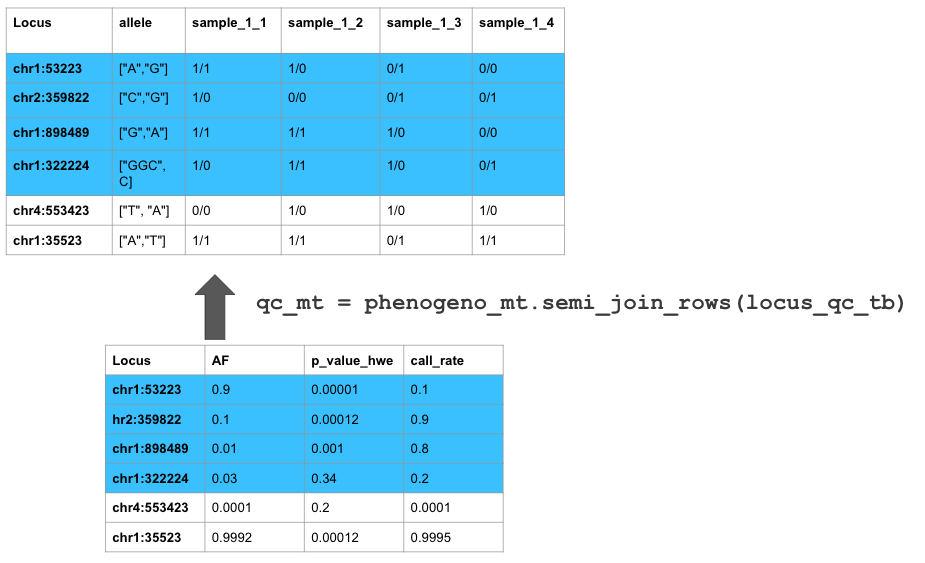

#### 3a) Filter sample QC Table

The above figure illustrates the basic process for filtering on Sample QC metrics. We first need to build the sample_qc table called `pre_sample_qc_tb`. Then we will extract the row fields using the `.row()` accessor and write it to DNAX using `pre_sample_qc_table.write()`. (see https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/sample_qc.ipynb for more info)

This table was built using:

```
pre_sample_qc_tb = hl.sample_qc(mt).cols()
```

In [6]:
# Define sample QC Table url

sample_qc_url = "dnax://database-GQYV2Bj04bPg9X3KfFyj2jyY/sample_qc.ht"

In [7]:
# Read sample QC Table

pre_sample_qc_tb = hl.read_table(sample_qc_url)

In [10]:
# View structure of sample QC Table

pre_sample_qc_tb.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'sample_qc': struct {
        dp_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        gq_stats: struct {
            mean: float64, 
            stdev: float64, 
            min: float64, 
            max: float64
        }, 
        call_rate: float64, 
        n_called: int64, 
        n_not_called: int64, 
        n_filtered: int64, 
        n_hom_ref: int64, 
        n_het: int64, 
        n_hom_var: int64, 
        n_non_ref: int64, 
        n_singleton: int64, 
        n_snp: int64, 
        n_insertion: int64, 
        n_deletion: int64, 
        n_transition: int64, 
        n_transversion: int64, 
        n_star: int64, 
        r_ti_tv: float64, 
        r_het_hom_var: float64, 
        r_insertion_deletion: float64
    } 
-----------------------------

Let's plot the call rate across the samples. This will help us decide what our cutoff should be.

In [8]:
from bokeh.io import output_notebook, show
output_notebook()

p = hl.plot.histogram(pre_sample_qc_tb["sample_qc"]["call_rate"])
show(p)

Loading BokehJS ...

Let's filter for samples that have a call rate greater or equal to 0.99

In [9]:
# Filter sample QC Table using expressions
# Note: Viewing the structure of the sample QC table in from the cell above 
# shows us that the "call_rate" field is within the "sample_qc" struct field

sample_qc_tb = pre_sample_qc_tb.filter(
    pre_sample_qc_tb["sample_qc"]["call_rate"] >= 0.99) 

In [11]:
# View number of samples in QC Table before and after filtering
#
# Note: running this cell can be computationally expensive and take
# longer for bigger datasets (this cell can be commented out).

print(f"Num samples before filtering: {pre_sample_qc_tb.count()}")
print(f"Num samples after filtering: {sample_qc_tb.count()}")

Num samples before filtering: 100000
Num samples after filtering: 50062


#### 3b) Filter MT with Sample QC Table

Now we can use `.semi_join_cols()` to filter our `phenogeno_mt` with `sample_qc_tb`.

In [10]:
# Filter the MT using the sample QC Table

qc_mt = phenogeno_mt.semi_join_cols(sample_qc_tb)

#### 4a) Extract Locus QC table

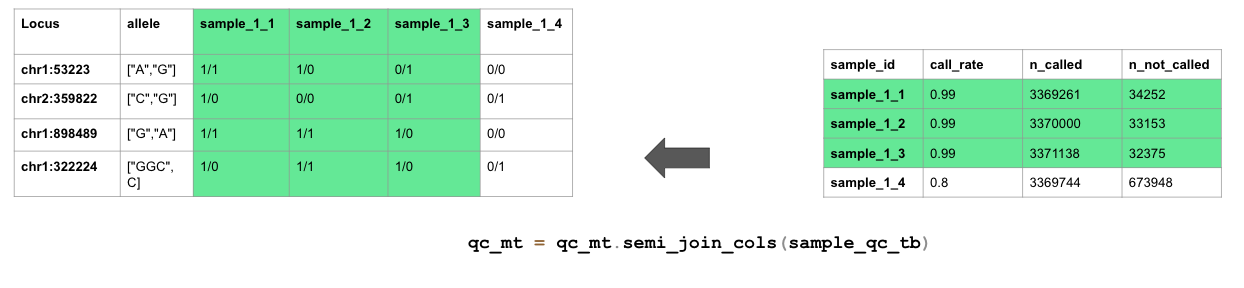



This table was built using

```
pre_locus_qc_tb = hl.variant_qc(mt).rows() 
```

(see https://github.com/dnanexus/OpenBio/blob/master/hail_tutorial/locus_qc.ipynb for more info)

In [11]:
# Define locus QC Table url

locus_qc_url = "dnax://database-GQYV2Bj04bPg9X3KfFyj2jyY/variant_qc.ht"

In [12]:
# Read locus QC Table

pre_locus_qc_tb = hl.read_table(locus_qc_url)

In [23]:
# View structure of locus QC Table

pre_locus_qc_tb.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        VQSR_culprit: str, 
        VQSR_NEGATIVE_TRAIN_SITE: bool, 
        VQSR_POSITIVE_TRAIN_SITE: bool, 
        GQ_HIST_ALT: array<str>, 
        DP_HIST_ALT: array<str>, 
        AB_HIST_ALT: array<str>, 
        GQ_HIST_ALL: str, 
        DP_HIST_ALL: str, 
        AB_HIST_ALL: str, 
        AC_AFR: array<int32>, 
        AC_AMR: array<in

Let's filter for loci that have:
- an AF value between 0.001-0.999,
- a HWE p-value greater or equal to 1e-10,
- a call rate greater or equal to 0.9

In [13]:
# Filter QC Table using expressions
# Note: Viewing the structure of the locus QC table in from the cell above 
# shows us that the "AF", "p_value_hwe", and "call_rate" fields are within
# the "variant_qc" struct field.

locus_qc_tb = pre_locus_qc_tb.filter(
    (pre_locus_qc_tb["variant_qc"]["AF"][0] >= 0.001) & 
    (pre_locus_qc_tb["variant_qc"]["AF"][0] <= 0.999) & 
    (pre_locus_qc_tb["variant_qc"]["p_value_hwe"] >= 1e-10) & 
    (pre_locus_qc_tb["variant_qc"]["call_rate"] >= 0.9)
)

In [23]:
# DON'T RUN in class
# View number of loci in QC Table before and after filtering
#
# Note: running this cell can be computationally expensive and take
# longer for bigger datasets (this cell can be commented out).

print(f"Num loci before filtering: {pre_locus_qc_tb.count()}")
print(f"Num loci after filtering: {locus_qc_tb.count()}")

Num loci before filtering: 3403513

Num loci after filtering: 39952


#### 4b) Filter MT with variant QC Tables

Now we can use `.semi_join_rows()` to filter our `phenogeno_mt` with `locus_qc_tb`.

In [14]:
# Filter the MT using the locus QC Table

qc_mt = qc_mt.semi_join_rows(locus_qc_tb)

In [15]:
# DON'T RUN in class
# View MT after QC filters
# 
# Note: running 'mt.rows().count()' or 'mt.cols().count()' can be computationally 
# expensive and take longer for bigger datasets (these lines can be commented out).

print(f"Num partitions: {qc_mt.n_partitions()}")
print(f"Num loci: {qc_mt.rows().count()}")
print(f"Num samples: {qc_mt.cols().count()}")
qc_mt.describe()

Num partitions: 228
Num loci: 39952


2023-04-19 22:33:57 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


Num samples: 50062
----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
    'fid': str
    'father_iid': int32
    'mother_iid': int32
    'sex_code': int32
    'case_control_status': int32
    'ccs': int32
    'sc': int32
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MQ: float64, 
        MQRankSum: float64, 
        QD: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        VQSR_culprit: str, 
        VQSR_NEGATIVE_TRAIN_SITE: bool, 
        VQSR_POSITIVE_TRAIN_SITE: bool, 
    

## 5) Run GWAS

Quick reminder that our pheno file has a lot of missing values, so we're going to be dropping a bunch of samples when we do our analysis.

In [18]:
qc_mt.ccs.show()

,
s,ccs
str,int32
"""sample_1_1""",NA
"""sample_1_3""",0
"""sample_1_6""",NA
"""sample_1_9""",NA
"""sample_1_10""",1
"""sample_1_11""",NA
"""sample_1_12""",NA
"""sample_1_13""",NA


Additional documentation: https://hail.is/docs/0.2/methods/stats.html#hail.methods.logistic_regression_rows

In [16]:
# Run Hail's logistic regression method

gwas = hl.logistic_regression_rows(test="firth",
                                   y=qc_mt.col.ccs, # the column field of the pheno trait we are looking at ('ccs')
                                   x=qc_mt.GT.n_alt_alleles(), # n_alt_alleles() returns the count of non-reference alleles
                                   covariates=[1, qc_mt.col.sc])

2023-04-19 22:34:55 Hail: WARN: 40104 of 50062 samples have a missing phenotype or covariate.
2023-04-19 22:34:55 Hail: INFO: logistic_regression_rows: running firth on 9958 samples for response variable y,
    with input variable x, and 2 additional covariates...


In [29]:
# View structure of GWAS results Table

gwas.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'beta': float64 
    'chi_sq_stat': float64 
    'p_value': float64 
    'fit': struct {
        n_iterations: int32, 
        converged: bool, 
        exploded: bool
    } 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [19]:
gwas.show()

+---------------+--------------+-----------+-------------+----------+
| locus         | alleles      |      beta | chi_sq_stat |  p_value |
+---------------+--------------+-----------+-------------+----------+
| locus<GRCh38> | array<str>   |   float64 |     float64 |  float64 |
+---------------+--------------+-----------+-------------+----------+
| chr1:12719    | ["G","C"]    |  1.96e-02 |    1.35e-02 | 9.08e-01 |
| chr1:13380    | ["C","G"]    | -3.00e-01 |    9.08e-01 | 3.41e-01 |
| chr1:13494    | ["A","G"]    | -3.33e-01 |    6.83e-01 | 4.09e-01 |
| chr1:13504    | ["G","A"]    |  1.50e-01 |    2.84e-01 | 5.94e-01 |
| chr1:17358    | ["ACTT","A"] |  4.46e-01 |    1.30e+00 | 2.54e-01 |
| chr1:17373    | ["A","G"]    | -3.88e-02 |    4.94e-02 | 8.24e-01 |
| chr1:17379    | ["G","A"]    |  4.65e-01 |    2.92e+00 | 8.72e-02 |
| chr1:17403    | ["A","G"]    |  1.51e-01 |    1.41e-01 | 7.07e-01 |
| chr1:17408    | ["C","G"]    | -8.03e-02 |    1.80e-01 | 6.71e-01 |
| chr1:69735    | ["A","G"]    |  7.29e-02 |    3.18e-02 | 8.59e-01 |
+---------------+--------------+-----------+-------------+----------+

+------------------+---------------+--------------+
| fit.n_iterations | fit.converged | fit.exploded |
+------------------+---------------+--------------+
|            int32 |          bool |         bool |
+------------------+---------------+--------------+
|                3 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
+------------------+---------------+--------------+
showing top 10 rows

In [31]:

pandas_gwas = gwas.to_pandas()
pandas_gwas.to_csv("gwas_results.csv")

## 6) Visualize GWAS results

Bokeh is a Python library that is included in this JupyterLab environment- which makes it easy for us to import.

We'll need the `output_notebook` and `show` modules to make our plots.

In [17]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [20]:
qq_plot = hl.plot.qq(gwas.p_value)
show(qq_plot)

2023-04-19 22:12:04 Hail: INFO: Ordering unsorted dataset with network shuffle


In [ ]:
manhattan_plot = hl.plot.manhattan(gwas_tb.p_value)
show(manhattan_plot)

## 7) Annotate GWAS results

Now that we have our GWAS results, we'll annotate our file using Hail's experimental DB, which is hosted on Open Data on AWS. This resource is not available in the RAP region. Here we're going to add GENCODE annotations to our matrix. There are a lot of other annotations available in the DB as well.

There is the query builder if you have access to the experimental annotations. This will help you write your `db.annotate_rows_db()` statement. 

https://hail.is/docs/0.2/annotation_database_ui.html#database-query 



In [18]:
db = hl.experimental.DB(region='us', cloud='aws')
ann_gwas_tb = db.annotate_rows_db(gwas, 'gencode')
ann_gwas_tb.show()

+---------------+--------------+-----------+-------------+----------+
| locus         | alleles      |      beta | chi_sq_stat |  p_value |
+---------------+--------------+-----------+-------------+----------+
| locus<GRCh38> | array<str>   |   float64 |     float64 |  float64 |
+---------------+--------------+-----------+-------------+----------+
| chr1:12719    | ["G","C"]    |  1.96e-02 |    1.35e-02 | 9.08e-01 |
| chr1:13380    | ["C","G"]    | -3.00e-01 |    9.08e-01 | 3.41e-01 |
| chr1:13494    | ["A","G"]    | -3.33e-01 |    6.83e-01 | 4.09e-01 |
| chr1:13504    | ["G","A"]    |  1.50e-01 |    2.84e-01 | 5.94e-01 |
| chr1:17358    | ["ACTT","A"] |  4.46e-01 |    1.30e+00 | 2.54e-01 |
| chr1:17373    | ["A","G"]    | -3.88e-02 |    4.94e-02 | 8.24e-01 |
| chr1:17379    | ["G","A"]    |  4.65e-01 |    2.92e+00 | 8.72e-02 |
| chr1:17403    | ["A","G"]    |  1.51e-01 |    1.41e-01 | 7.07e-01 |
| chr1:17408    | ["C","G"]    | -8.03e-02 |    1.80e-01 | 6.71e-01 |
| chr1:69735    | ["A","G"]    |  7.29e-02 |    3.18e-02 | 8.59e-01 |
+---------------+--------------+-----------+-------------+----------+

+------------------+---------------+--------------+
| fit.n_iterations | fit.converged | fit.exploded |
+------------------+---------------+--------------+
|            int32 |          bool |         bool |
+------------------+---------------+--------------+
|                3 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
+------------------+---------------+--------------+

+------------------------------------------------------------------------------+
| gencode                                                                      |
+------------------------------------------------------------------------------+
| array<struct{ID: str, gene_id: str, gene_name: str, gene_type: str, level... |
+------------------------------------------------------------------------------+
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000227232.5","ENSG00000227232.5","WASH7P","unprocessed_pseudogen... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000186092.6","ENSG00000186092.6","OR4F5","protein_coding","2","g... |
+------------------------------------------------------------------------------+
showing top 10 rows

On RAP, we do not have access to this resource, as it isn't available in the UKB RAP region, so we must use the Hail/VEP configuration (note we started with the Hail/VEP features).

`hl.vep()` requires a config file in JSON format. I have used the one available here: https://documentation.dnanexus.com/user/jupyter-notebooks/dxjupyterlab-spark-cluster#using-vep-with-hail

In [19]:
ann_gwas_tb2 = hl.vep(ann_gwas_tb, "file:///mnt/project/notebooks/config.json")
ann_gwas_tb2.show()

+---------------+--------------+-----------+-------------+----------+
| locus         | alleles      |      beta | chi_sq_stat |  p_value |
+---------------+--------------+-----------+-------------+----------+
| locus<GRCh38> | array<str>   |   float64 |     float64 |  float64 |
+---------------+--------------+-----------+-------------+----------+
| chr1:12719    | ["G","C"]    |  1.96e-02 |    1.35e-02 | 9.08e-01 |
| chr1:13380    | ["C","G"]    | -3.00e-01 |    9.08e-01 | 3.41e-01 |
| chr1:13494    | ["A","G"]    | -3.33e-01 |    6.83e-01 | 4.09e-01 |
| chr1:13504    | ["G","A"]    |  1.50e-01 |    2.84e-01 | 5.94e-01 |
| chr1:17358    | ["ACTT","A"] |  4.46e-01 |    1.30e+00 | 2.54e-01 |
| chr1:17373    | ["A","G"]    | -3.88e-02 |    4.94e-02 | 8.24e-01 |
| chr1:17379    | ["G","A"]    |  4.65e-01 |    2.92e+00 | 8.72e-02 |
| chr1:17403    | ["A","G"]    |  1.51e-01 |    1.41e-01 | 7.07e-01 |
| chr1:17408    | ["C","G"]    | -8.03e-02 |    1.80e-01 | 6.71e-01 |
| chr1:69735    | ["A","G"]    |  7.29e-02 |    3.18e-02 | 8.59e-01 |
+---------------+--------------+-----------+-------------+----------+

+------------------+---------------+--------------+
| fit.n_iterations | fit.converged | fit.exploded |
+------------------+---------------+--------------+
|            int32 |          bool |         bool |
+------------------+---------------+--------------+
|                3 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
|                4 |          True |        False |
|                5 |          True |        False |
+------------------+---------------+--------------+

+------------------------------------------------------------------------------+
| gencode                                                                      |
+------------------------------------------------------------------------------+
| array<struct{ID: str, gene_id: str, gene_name: str, gene_type: str, level... |
+------------------------------------------------------------------------------+
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000223972.5","ENSG00000223972.5","DDX11L1","transcribed_unproces... |
| [("ENSG00000227232.5","ENSG00000227232.5","WASH7P","unprocessed_pseudogen... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000278267.1","ENSG00000278267.1","MIR6859-1","miRNA","3","gene",... |
| [("ENSG00000186092.6","ENSG00000186092.6","OR4F5","protein_coding","2","g... |
+------------------------------------------------------------------------------+

+-------------------+-------------------+---------------+
| vep.assembly_name | vep.allele_string | vep.ancestral |
+-------------------+-------------------+---------------+
| str               | str               | str           |
+-------------------+-------------------+---------------+
| "GRCh38"          | "G/C"             | NA            |
| "GRCh38"          | "C/G"             | NA            |
| "GRCh38"          | "A/G"             | NA            |
| "GRCh38"          | "G/A"             | NA            |
| "GRCh38"          | "CTT/-"           | NA            |
| "GRCh38"          | "A/G"             | NA            |
| "GRCh38"          | "G/A"             | NA            |
| "GRCh38"          | "A/G"             | NA         

## 8) Export GWAS Table, Export MT to BGEN

We can convert our Hail GWAS table and bring it into memory using the `.to_pandas()` method. Then we can write it to HDFS using `.to_csv()`. 

In [ ]:
# Convert to Pandas DataFrame
ann_gwas_pd = ann_gwas_tb.to_pandas()
# Save as CSV file to Hadoop File System
ann_gwas_pd.to_csv("gwas-results.csv")

Our `gwas-results.csv` file is now in the Hadoop File System. Then we can run `hdfs get` to pull it onto the disk of the Driver node. Then we can use `dx upload` to get it into project storage.

In [ ]:
%%bash

#Fetch results file from Hadoop File System and save to Driver Node Storage
hdfs dfs -get gwas-results.csv
#Upload resutls file to Project Storage
dx upload gwas-results.csv --destination "/users/tladeras/"

If we want to output BGEN files, there is no direct way for the notebook to write data into the project, so we will first write into HDFS (see https://documentation.dnanexus.com/developer/apps/developing-spark-apps#spark-cluster-management-software). 

After writing out the BGEN files to HDFS, we can then move the data to the project in the next step as above.

*Additional documentation: https://hail.is/docs/0.2/methods/impex.html#hail.methods.export_bgen*

In [38]:
# Create a set of unique chromosomes found in MT

chr_set = mt.aggregate_rows(hl.agg.collect_as_set(mt.locus.contig))

In [ ]:
# Filter MT to a single chromosome and write out as BGEN file to HDFS as a single file for each chromosome in the MT
for chrom in chr_set:
    filtered_mt = hl.filter_intervals(mt, [hl.parse_locus_interval(chrom, reference_genome="GRCh38"),])
    hl.export_bgen(filtered_mt, f"{chrom}")

In [ ]:
%%bash
# Copy BGEN files from HDFS to the JupyterLab execution environment file system

hdfs dfs -get ./*.bgen .

In [ ]:
%%bash
# Copy SAMPLE files from HDFS to the JupyterLab execution environment file system

hdfs dfs -get ./*.sample .

In [71]:
%%bash
# Upload BGEN and SAMPLE files to project

dx upload *.bgen
dx upload *.sample

Finally, we can save our filtered MatrixTable to `dnax` so we can use it later.

In [ ]:
# Store Table in DNAXc

import dxpy

# find database ID of newly created database using a dxpy methodc
db_uri = dxpy.find_one_data_object(name=f"{db_name}", classname="database")['id']
url = f"dnax://{db_uri}/{tb_name}"

# Before this step, the Hail Table is just an object in memory. To persist it and be able to access 
# it later, the notebook needs to write it into a persistent filesystem (in this case DNAX).
# See https://hail.is/docs/0.2/hail.Table.html#hail.Table.write for additional documentation.
qc_tb.write(url) # Note: output should describe size of Table (i.e. number of rows, partitions)